In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# Default value for amount of intervals per octave
intervals_per_octave = 3

# Default value for amount of octaves
num_of_octaves = 8

# Default value for initial gaussian blur
sigma = 1.6

# Default value for contrast threshold
contrast_threshold = 0.04

# Default value for edge threshold
edge_threshold = 10

# Assumed gaussian blur for input image
initial_sigma = 0.5

# Default value for max interpolation steps
max_interp_steps = 5

# Double image size
double_image_size = False

# Default value for number of layers in octave
num_of_layers_in_octave = 3


In [3]:
def create_initial_image(img, double_image_size, sigma):
    if double_image_size:
        sig_diff = np.sqrt(sigma * sigma - initial_sigma * initial_sigma * 4)
        img = cv2.resize(img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
        img = cv2.GaussianBlur(img, (0, 0), sig_diff)
    else:
        sig_diff = np.sqrt(sigma * sigma - initial_sigma * initial_sigma)
        img = cv2.GaussianBlur(img, (0, 0), sig_diff)

    # Convert to float32
    img = img.astype(np.float32)

    return img

In [4]:
img = create_initial_image(cv2.imread('images/foto2.jpeg', cv2.IMREAD_GRAYSCALE), double_image_size, sigma)

In [5]:
def build_gaussian_pyramid(base, nOctaves, nOctaveLayers, sigma):
    sig = [0] * (nOctaveLayers + 3)
    pyr = [None] * (nOctaves * (nOctaveLayers + 3))  # flat list

    # Precompute Gaussian sigmas
    sig[0] = sigma
    k = 2.0 ** (1.0 / nOctaveLayers)
    for i in range(1, nOctaveLayers + 3):
        sig_prev = (k ** (i - 1)) * sigma
        sig_total = sig_prev * k
        sig[i] = np.sqrt(sig_total ** 2 - sig_prev ** 2)

    for o in range(nOctaves):
        for i in range(nOctaveLayers + 3):
            idx = o * (nOctaveLayers + 3) + i
            if o == 0 and i == 0:
                pyr[idx] = base.copy()
            elif i == 0:
                # Downsample last layer of previous octave
                src = pyr[(o - 1) * (nOctaveLayers + 3) + nOctaveLayers]
                pyr[idx] = cv2.resize(src, (src.shape[1] // 2, src.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
            else:
                src = pyr[o * (nOctaveLayers + 3) + i - 1]
                blurred = cv2.GaussianBlur(src, (0, 0), sig[i], sig[i])
                pyr[idx] = blurred

    return pyr

pyr = build_gaussian_pyramid(img, num_of_octaves, num_of_layers_in_octave, sigma)
print(len(pyr))


48


In [ ]:
# Plot the gaussian pyramid
# Array is len(24). 4 octaves with 6 images each
# Each row is an octave

fig, axes = plt.subplots(4, 6, figsize=(15, 10))
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.imshow(pyr[i], cmap='gray')
    # Get image dimensions
    height, width = pyr[i].shape
    ax.set_title(f'{width}x{height}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [41]:
def build_DoG_pyramid(gpyr, nOctaveLayers):
    nOctaves = len(gpyr) // (nOctaveLayers + 3)
    dogpyr = [None] * (nOctaves * (nOctaveLayers + 2))

    for o in range(nOctaves):
        for i in range(nOctaveLayers + 2):
            idx1 = o * (nOctaveLayers + 3) + i
            idx2 = idx1 + 1
            dst_idx = o * (nOctaveLayers + 2) + i
            src1 = gpyr[idx1]
            src2 = gpyr[idx2]
            # Difference of Gaussians: src2 - src1
            dogpyr[dst_idx] = cv2.subtract(src2, src1)

    return dogpyr

dog_pyramid = build_DoG_pyramid(pyr, num_of_layers_in_octave)
print(len(dog_pyramid))

20


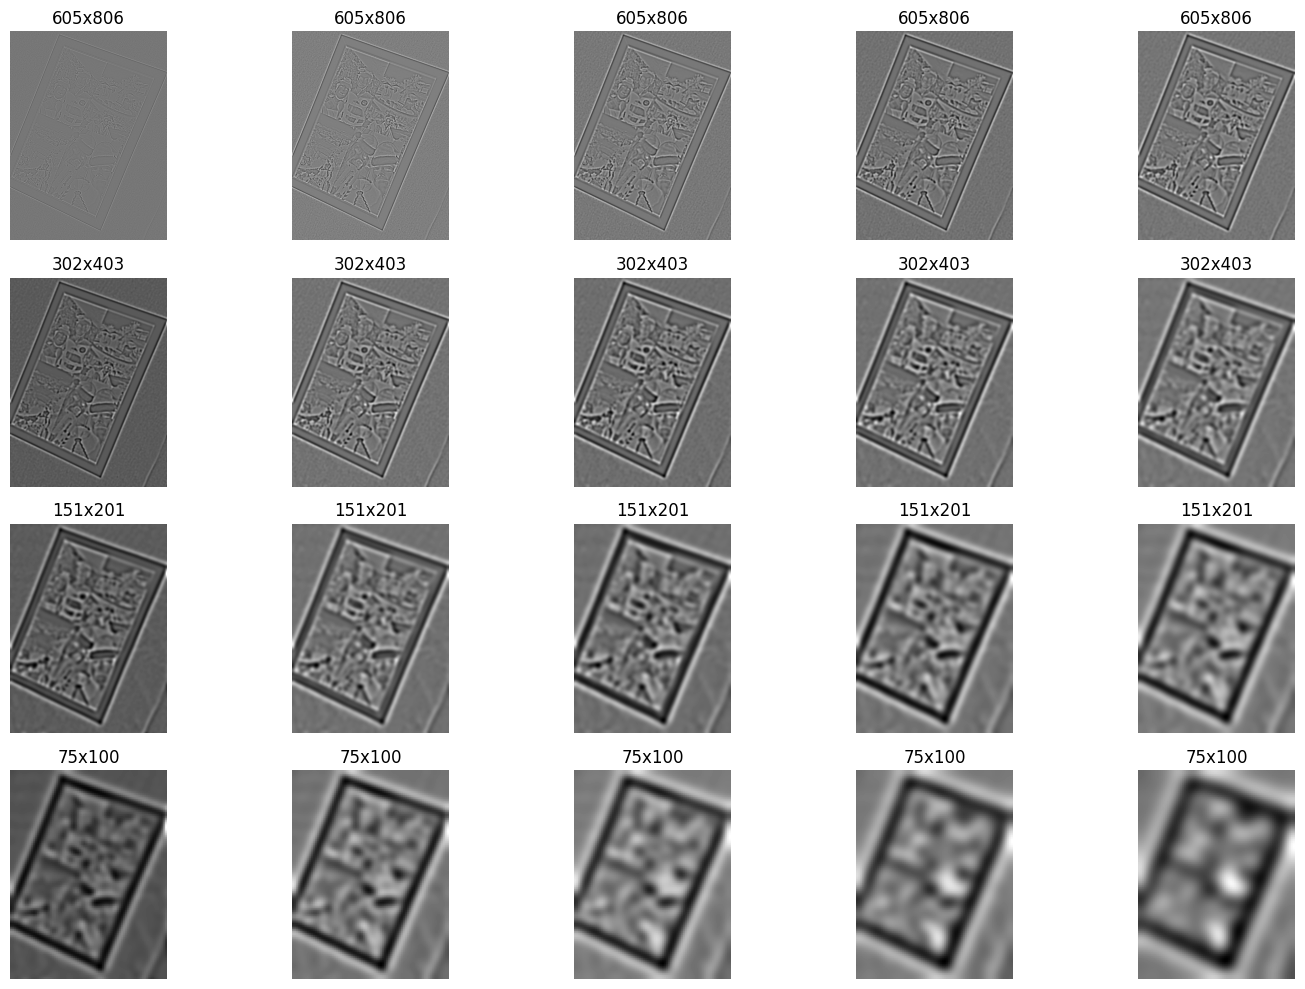

In [ ]:
# Plot the DoG pyramid
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.imshow(dog_pyramid[i], cmap='gray')
    # Get image dimensions
    height, width = dog_pyramid[i].shape
    ax.set_title(f'{width}x{height}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [43]:
def reshape_dog_pyramid(dogpyr_flat, nOctaveLayers):
    nOctaves = len(dogpyr_flat) // (nOctaveLayers + 2)
    dogpyr = []

    for o in range(nOctaves):
        start = o * (nOctaveLayers + 2)
        end = start + (nOctaveLayers + 2)
        octave = dogpyr_flat[start:end]
        dogpyr.append(octave)

    return dogpyr

In [44]:
def find_local_extrema(dogpyr, nOctaveLayers, num_octaves):
    # Reshape the DoG pyramid to a 2D array (nOctaves, nOctaveLayers + 2)
    dogpyr_2d = reshape_dog_pyramid(dogpyr, nOctaveLayers)

    # Get keypoints (Local extrema)
    keypoints = []

    for octave in range(num_octaves):
        for img in range(nOctaveLayers + 2):
            print(octave, img)
            for (x,y) in np.ndindex(dogpyr_2d[octave][img].shape):
                if x == 0 or x == dogpyr_2d[octave][img].shape[0] - 1 or y == 0 or y == dogpyr_2d[octave][img].shape[1] - 1:
                    continue # Skip the edges
                if img == nOctaveLayers + 1 or img == 0:
                    continue
                # Get the values of the 26 neighbors of the pixel
                neighbors_at_level = [] # 8 neighbors at the same level
                neighbors_at_level.append(dogpyr_2d[octave][img][x, y+1])
                neighbors_at_level.append(dogpyr_2d[octave][img][x, y-1])
                neighbors_at_level.append(dogpyr_2d[octave][img][x+1, y])
                neighbors_at_level.append(dogpyr_2d[octave][img][x-1, y])
                neighbors_at_level.append(dogpyr_2d[octave][img][x+1, y+1])
                neighbors_at_level.append(dogpyr_2d[octave][img][x-1, y-1])
                neighbors_at_level.append(dogpyr_2d[octave][img][x+1, y-1])
                neighbors_at_level.append(dogpyr_2d[octave][img][x-1, y+1])
                

                neighbors_above = [] # 9 neighbors above
                neighbors_above.append(dogpyr_2d[octave][img + 1][x, y])
                neighbors_above.append(dogpyr_2d[octave][img + 1][x, y+1])
                neighbors_above.append(dogpyr_2d[octave][img + 1][x, y-1])
                neighbors_above.append(dogpyr_2d[octave][img + 1][x+1, y])
                neighbors_above.append(dogpyr_2d[octave][img + 1][x-1, y])
                neighbors_above.append(dogpyr_2d[octave][img + 1][x+1, y+1])
                neighbors_above.append(dogpyr_2d[octave][img + 1][x-1, y-1])
                neighbors_above.append(dogpyr_2d[octave][img + 1][x+1, y-1])
                neighbors_above.append(dogpyr_2d[octave][img + 1][x-1, y+1])

            
                neighbors_below = [] # 9 neighbors below
                neighbors_below.append(dogpyr_2d[octave][img - 1][x, y])
                neighbors_below.append(dogpyr_2d[octave][img - 1][x, y+1])
                neighbors_below.append(dogpyr_2d[octave][img - 1][x, y-1])
                neighbors_below.append(dogpyr_2d[octave][img - 1][x+1, y])
                neighbors_below.append(dogpyr_2d[octave][img - 1][x-1, y])
                neighbors_below.append(dogpyr_2d[octave][img - 1][x+1, y+1])
                neighbors_below.append(dogpyr_2d[octave][img - 1][x-1, y-1])
                neighbors_below.append(dogpyr_2d[octave][img - 1][x+1, y-1])
                neighbors_below.append(dogpyr_2d[octave][img - 1][x-1, y+1])
        
                # Concat all neighbors
                neighbors = np.concatenate([neighbors_at_level, neighbors_above, neighbors_below])

                # Check if the pixel is a local extremum
                if dogpyr_2d[octave][img][x, y] > np.max(neighbors) or dogpyr_2d[octave][img][x, y] < np.min(neighbors):
                    octave_idx = img
                    keypoints.append((x, y, octave, octave_idx))

    return keypoints

keypoints = find_local_extrema(dog_pyramid, num_of_layers_in_octave, num_of_octaves)
print(len(keypoints))

574


In [45]:
def compute_gradient(x, y, octave, octave_idx, dog_pyramid2d):
    dx = (dog_pyramid2d[octave][octave_idx][x+1, y].astype(np.float32) - dog_pyramid2d[octave][octave_idx][x-1, y].astype(np.float32)) / 2
    dy = (dog_pyramid2d[octave][octave_idx][x, y+1].astype(np.float32) - dog_pyramid2d[octave][octave_idx][x, y-1].astype(np.float32)) / 2
    ds = (dog_pyramid2d[octave][octave_idx+1][x, y].astype(np.float32) - dog_pyramid2d[octave][octave_idx-1][x, y].astype(np.float32)) / 2
    return np.array([dx, dy, ds])

def compute_hessian(x, y, octave, octave_idx, dog_pyramid2d):
    dxx = dog_pyramid2d[octave][octave_idx][x+1, y].astype(np.float32) + dog_pyramid2d[octave][octave_idx][x-1, y].astype(np.float32) - 2*dog_pyramid2d[octave][octave_idx][x, y].astype(np.float32)
    dyy = dog_pyramid2d[octave][octave_idx][x, y+1].astype(np.float32) + dog_pyramid2d[octave][octave_idx][x, y-1].astype(np.float32) - 2*dog_pyramid2d[octave][octave_idx][x, y].astype(np.float32)
    dss = dog_pyramid2d[octave][octave_idx+1][x, y].astype(np.float32) + dog_pyramid2d[octave][octave_idx-1][x, y].astype(np.float32) - 2*dog_pyramid2d[octave][octave_idx][x, y].astype(np.float32)
    dxy = (dog_pyramid2d[octave][octave_idx][x+1, y+1].astype(np.float32) - dog_pyramid2d[octave][octave_idx][x+1, y-1].astype(np.float32) - dog_pyramid2d[octave][octave_idx][x-1, y+1].astype(np.float32) + dog_pyramid2d[octave][octave_idx][x-1, y-1].astype(np.float32)) / 4
    dxs = (dog_pyramid2d[octave][octave_idx+1][x+1, y].astype(np.float32) - dog_pyramid2d[octave][octave_idx+1][x-1, y].astype(np.float32) - dog_pyramid2d[octave][octave_idx-1][x+1, y].astype(np.float32) + dog_pyramid2d[octave][octave_idx-1][x-1, y].astype(np.float32)) / 4
    dys = (dog_pyramid2d[octave][octave_idx+1][x, y+1].astype(np.float32) - dog_pyramid2d[octave][octave_idx+1][x, y-1].astype(np.float32) - dog_pyramid2d[octave][octave_idx-1][x, y+1].astype(np.float32) + dog_pyramid2d[octave][octave_idx-1][x, y-1].astype(np.float32)) / 4
    return np.array([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])

def is_low_contrast(grad, x_hat, D_value, threshold=contrast_threshold):
    contrast = D_value + 0.5 * grad @ x_hat
    return abs(contrast) < threshold

def is_edge_like(H, r=10):
    D_xx = H[0, 0]
    D_yy = H[1, 1]
    D_xy = H[0, 1]

    Tr = D_xx + D_yy
    Det = D_xx * D_yy - D_xy**2

    if Det <= 0:
        return True  # unstable, reject

    edge_score = (Tr ** 2) / Det
    threshold = ((r + 1) ** 2) / r
    return edge_score > threshold

def compute_accurate_keypoint(keypoint, dog_pyramid2d, max_iter=max_interp_steps):
    x, y, octave, octave_idx = keypoint
    for _ in range(max_iter):
        grad = compute_gradient(x, y, octave, octave_idx, dog_pyramid2d)
        H = compute_hessian(x, y, octave, octave_idx, dog_pyramid2d)

        try:
            x_hat = -np.linalg.inv(H) @ grad
        except np.linalg.LinAlgError:
            return None  # Discard unstable keypoint

        if np.any(np.abs(x_hat) > 0.5):
            x_new = int(round(x + x_hat[0]))
            y_new = int(round(y + x_hat[1]))
            idx_new = int(round(octave_idx + x_hat[2]))

            # Bounds check
            if (
                x_new < 1 or y_new < 1 or
                x_new >= dog_pyramid2d[octave][0].shape[0] - 1 or
                y_new >= dog_pyramid2d[octave][0].shape[1] - 1 or
                idx_new < 1 or idx_new >= len(dog_pyramid2d[octave]) - 1
            ):
                return None  # Discard keypoint

            x, y, octave_idx = x_new, y_new, idx_new
        else:
            # Refinement successful
            break

    # Now apply contrast and edge filtering AFTER refinement
    D_value = dog_pyramid2d[octave][octave_idx][x, y]
    if is_low_contrast(grad, x_hat, D_value):
        return None

    if is_edge_like(H[0:2, 0:2]):
        return None

    x_refined = x + x_hat[0]
    y_refined = y + x_hat[1]
    scale_refined = octave_idx + x_hat[2]

    return np.array([x_refined, y_refined, octave, scale_refined])


accurate_keypoints = []
for keypoint in keypoints:
    accurate_keypoint = compute_accurate_keypoint(keypoint, reshape_dog_pyramid(dog_pyramid, num_of_layers_in_octave))
    if accurate_keypoint is not None:
        accurate_keypoints.append(accurate_keypoint)

print(len(accurate_keypoints))



339


In [46]:
# Convert keypoints to image coordinates and scale
keypoints_scaled = []
for keypoint in accurate_keypoints:
    x, y, octave, scale = keypoint
    x = x * 2**octave
    y = y * 2**octave
    k = 2**(1/intervals_per_octave)
    scale = sigma * (2 ** octave) * (k ** scale)
    keypoints_scaled.append((x, y, scale))

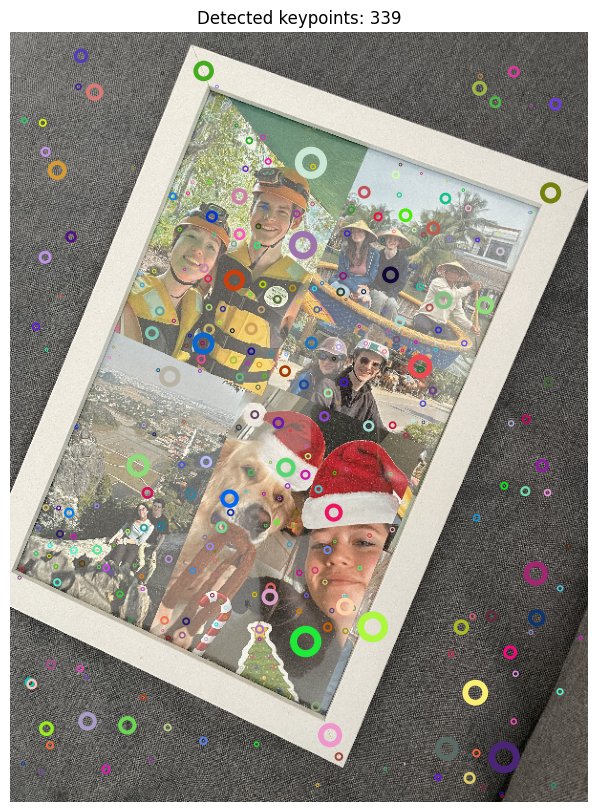

In [48]:
# If original_img is grayscale, convert to RGB for colorful plotting
img = cv2.imread('images/foto2.jpeg')
img = cv2.resize(img, (0, 0), fx=0.2, fy=0.2, interpolation=cv2.INTER_CUBIC)
if len(img.shape) == 2:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
ax = plt.gca()

for (x, y, sigma) in keypoints_scaled:
    # Draw circle: radius can be sigma multiplied by a factor for better visibility
    circle = plt.Circle((y, x), sigma * 0.5, color=np.random.rand(3), fill=False, linewidth=0.2 * sigma)
    ax.add_patch(circle)

plt.axis('off')
plt.title(f'Detected keypoints: {len(keypoints_scaled)}')
plt.show()